## Data Cleaning & Dataframe Prep

This notebook handles the following tasks and prepares the data for the analysis.
If you something off, please fix it and add it to here.

Data Cleaning

- Delete NaN entries.
- Assign 0: Not Applicable to the Empirical Novelty that has been chosen as "Not Applicaple". We have observed that this occurs when reviewers think empirical novelty is not applicaple to a paper, which can be a theoretical one for instance. When calculating the mean of this, please do not include 0 entries.
- Ethics Flags include data which says both NO. and Yes, ... All of the contradictory entries included explanations, so we have accepted them as Yes.
- Delete reviews submitted after the deadline

Data Preparation

- Statistics related to each reviewer is calculated for each paper.
- These statics are: std, mean, diff(max_score-min_score)

### Resulting datasets

- review_df_clean -> reviewer per row cleaned data
- paper_df -> per paper dataframe, statistics are calculated such as mean, std, variance, max_min difference etc.
- df -> basic dataset

In [1]:
import pandas as pd 
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt

file_name = "../data/ICLR.cc-2023-Conference.csv"
df = pd.read_csv(file_name)

In [2]:
df.columns = df.columns.str.replace("recommendation", "score", regex=False)

### Dataframe 1: Reviewers as rows

In [3]:
# Instead of one row per paper, arrange data to have one reviewer per row.

reviewer_feature_cols = [col.split('reviewer1_')[1] for col in df.columns if col.startswith('reviewer1')]
for i in reviewer_feature_cols:
    print(i)
reviewer_cols = [col for col in df.columns for i in range(1, 5) if col.startswith('reviewer' + str(i) + '_')]
non_reviewer_cols = [col for col in df.columns if col not in reviewer_cols]


df['paper_no'] = np.arange(len(df))
review_df = pd.DataFrame(columns=['paper_id', 'reviewer', 'reviewer_score', 'reviewer_confidence', 'reviewer_summary_of_the_paper', 'reviewer_strength_and_weaknesses', 'reviewer_clarity_quality_novelty_and_reproducibility', 'reviewer_summary_of_the_review', 'reviewer_correctness', 'reviewer_technical_novelty_and_significance', 'reviewer_empirical_novelty_and_significance', 'reviewer_flag_for_ethics_review', 'reviewer_length', 'reviewer_cdate', 'reviewer_tmdate', 'title', 'keywords', 'TL;DR', 'abstract', 'cdate', 'tmdate', 'decision'])
for idx, row in df.iterrows():
    for i in range(1, 5):
        dict_ = {}
        for col in reviewer_feature_cols:
            dict_['reviewer'] = i
            dict_['reviewer' + '_' + col] = row['reviewer' + str(i) + '_' + col]
        for col in non_reviewer_cols:
            dict_[col] = row[col]
        dict_['paper_id'] = row['paper_no']
        review_df.loc[len(review_df)] = dict_

df.head()

score
confidence
summary_of_the_paper
strength_and_weaknesses
clarity_quality_novelty_and_reproducibility
summary_of_the_review
correctness
technical_novelty_and_significance
empirical_novelty_and_significance
flag_for_ethics_review
length
cdate
tmdate


,title,keywords,TL;DR,abstract,cdate,tmdate,reviewer1_score,reviewer1_confidence,reviewer1_summary_of_the_paper,reviewer1_strength_and_weaknesses,...,reviewer4_summary_of_the_review,reviewer4_correctness,reviewer4_technical_novelty_and_significance,reviewer4_empirical_novelty_and_significance,reviewer4_flag_for_ethics_review,reviewer4_length,reviewer4_cdate,reviewer4_tmdate,decision,paper_no
0,Guiding Safe Exploration with Weakest Precondi...,reinforcement learning; safe learning; safe ex...,"We use an online, weakest-precondition-based a...",In reinforcement learning for safety-critical ...,2022-09-22 14:36:24,2024-11-25 10:13:40,6: marginally above the acceptance threshold,"4: You are confident in your assessment, but n...",This paper deals with safe exploration in rein...,### Strength\n- Interesting and importance pro...,...,I like the proposed approach and its associate...,4: All of the claims and statements are well-s...,3: The contributions are significant and somew...,2: The contributions are only marginally signi...,NO.,3082.0,2022-11-03 08:08:39,2022-12-14 03:46:36,Accept: poster,0
1,An Adaptive Entropy-Regularization Framework f...,Multi-Agent Reinforcement Learning; Entropy Re...,This paper proposes an adaptive entropy-regul...,"In this paper, we propose an adaptive entropy-...",2022-09-22 14:33:17,2023-02-14 00:28:54,"3: reject, not good enough","4: You are confident in your assessment, but n...",This paper presents an MARL algorithm to adpat...,### Strengths\n\n1. This paper studies adaptiv...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reject,1
2,AutoSparse: Towards Automated Sparse Training,sparsity; sparse training; deep learning,NaN,Sparse training is emerging as a promising ave...,2022-09-22 14:32:39,2023-02-14 00:29:06,5: marginally below the acceptance threshold,"4: You are confident in your assessment, but n...",This paper first introduces a technique called...,Strengths:\n\n- Provided intuitive examples an...,...,1. The proposed method seems tricky and not el...,2: Several of the paper’s claims are incorrect...,2: The contributions are only marginally signi...,1: The contributions are neither significant n...,NO.,2254.0,2022-10-27 20:14:54,2022-10-27 20:14:54,Reject,2
3,Sampling is as easy as learning the score: the...,diffusion models; score-based generative model...,We prove that given an L2-accurate score estim...,We provide theoretical convergence guarantees ...,2022-09-22 14:40:10,2023-02-14 00:27:00,"8: accept, good paper","4: You are confident in your assessment, but n...",This paper examines the convergence of SGMs un...,Strength:\n\n- The presentation is clear.\n\n-...,...,Overall I think the paper introduces very stro...,3: Some of the paper’s claims have minor issue...,3: The contributions are significant and somew...,Not applicable,NO.,5316.0,2022-10-27 22:09:32,2022-10-27 22:09:32,Accept: notable-top-5%,3
4,RoCourseNet: Distributionally Robust Training ...,Counterfactual Explanation; Algorithmic Recour...,NaN,Counterfactual (CF) explanations for machine l...,2022-09-22 14:38:43,2024-11-25 10:12:40,"3: reject, not good enough","4: You are confident in your assessment, but n...",This submission proposed an approach to solvin...,Strength:\n\n1. The paper is easy to follow.\n...,...,The paper solves an important problem. The exp...,4: All of the claims and statements are well-s...,2: The contributions are only marginally signi...,2: The contributions are only marginally signi...,NO.,2937.0,2022-10-29 20:23:57,2022-10-29 20:23:57,Reject,4


### Data prep: convert and simplify column values 

1. Convert cdate to pandas datetime datatype.
2. Add time_to_deadline column which measures the time difference between the review submission and review deadline
3. To get the score part, remove the explanations from score columns such as recommendation.
4. Add a is_high_variance column to detect high discrepancy reviews.
5. There are different acceptances, like top-5-notable etc. We just treat them as expected, so simply those explanations.

In [4]:
df['reviewer1_cdate'] = pd.to_datetime(df['reviewer1_cdate'])
df['reviewer2_cdate'] = pd.to_datetime(df['reviewer2_cdate'])
df['reviewer3_cdate'] = pd.to_datetime(df['reviewer3_cdate'])
df['reviewer4_cdate'] = pd.to_datetime(df['reviewer4_cdate'])

df['reviewer1_time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - df['reviewer1_cdate']
df['reviewer2_time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - df['reviewer2_cdate']
df['reviewer3_time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - df['reviewer3_cdate']
df['reviewer4_time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - df['reviewer4_cdate']

df.dropna(subset=['reviewer1_cdate', 'reviewer2_cdate', 'reviewer3_cdate', 'reviewer4_cdate'], inplace=True)

df['reviewer1_score'] = df['reviewer1_score'].apply(lambda x: x.split(':')[0]).astype(int)
df['reviewer2_score'] = df['reviewer2_score'].apply(lambda x: x.split(':')[0]).astype(int)
df['reviewer3_score'] = df['reviewer3_score'].apply(lambda x: x.split(':')[0]).astype(int)
df['reviewer4_score'] = df['reviewer4_score'].apply(lambda x: x.split(':')[0]).astype(int)

df['max_score'] = df[['reviewer1_score', 'reviewer2_score', 'reviewer3_score', 'reviewer4_score']].max(axis=1)
df['min_score'] = df[['reviewer1_score', 'reviewer2_score', 'reviewer3_score', 'reviewer4_score']].min(axis=1)
df['max_min_score_diff'] = df['max_score'] - df['min_score']

df['is_high_variance'] = df['max_min_score_diff'] >= 4

df['decision'] = df['decision'].apply(lambda x: "Accept" if "accept" in x.lower() else "Reject")

Play with variables and check if the values are as expected:

In [5]:
df[df['decision'].eq("Accept") & df['is_high_variance']]

,title,keywords,TL;DR,abstract,cdate,tmdate,reviewer1_score,reviewer1_confidence,reviewer1_summary_of_the_paper,reviewer1_strength_and_weaknesses,...,decision,paper_no,reviewer1_time_to_deadline,reviewer2_time_to_deadline,reviewer3_time_to_deadline,reviewer4_time_to_deadline,max_score,min_score,max_min_score_diff,is_high_variance
32,PD-MORL: Preference-Driven Multi-Objective Rei...,multi-objective reinforcement learning; MORL; ...,A novel approach that obtains a single policy ...,Multi-objective reinforcement learning (MORL) ...,2022-09-22 14:37:04,2023-03-02 03:46:32,8,3: You are fairly confident in your assessment...,This work proposes an algorithm for solving mu...,The main strengths of this paper:\n- Novel app...,...,Accept,32,11 days 07:56:58,10 days 08:47:26,8 days 00:55:32,2 days 05:53:11,8,3,5,True
33,CircNet: Meshing 3D Point Clouds with Circumce...,Meshing; 3D Point Cloud; Point Cloud Triangula...,We present a deep neural architecture that det...,Reconstructing 3D point clouds into triangle m...,2022-09-22 14:34:26,2024-11-25 10:14:38,8,"4: You are confident in your assessment, but n...",This paper tackles the problem of point cloud ...,Strength\n+ The formulation of the problem as ...,...,Accept,33,15 days 11:46:51,13 days 09:18:49,0 days 01:53:56,-2 days +00:26:53,8,3,5,True
34,Semi-supervised learning with a principled lik...,Bayesian deep learning; Bayesian neural networ...,"We develop Bayesian semi-supervised learning, ...",We currently do not have an understanding of s...,2022-09-22 14:34:48,2023-02-21 09:35:10,5,"4: You are confident in your assessment, but n...",The authors consider the fact that our common ...,## Strengths\nThe paper is well argued for and...,...,Accept,34,16 days 15:04:34,10 days 04:45:05,10 days 01:48:15,7 days 20:28:22,8,3,5,True
37,Is Adversarial Training Really a Silver Bullet...,Data poisoning; adversarial training; indiscri...,We propose an indiscriminative feature-based p...,Indiscriminate data poisoning can decrease the...,2022-09-22 14:36:10,2023-03-02 17:30:28,6,"4: You are confident in your assessment, but n...",In this work the authors attack in models in t...,Strengths:\n* The method is novel and obtains ...,...,Accept,37,11 days 15:48:46,11 days 07:24:56,10 days 03:36:11,7 days 22:02:29,10,6,4,True
55,Red PANDA: Disambiguating Image Anomaly Detect...,Anomaly Detection; Disentanglement,Proposing a new anomaly detection setting when...,Anomaly detection methods strive to discover p...,2022-09-22 14:35:53,2023-03-02 12:44:02,6,3: You are fairly confident in your assessment...,This paper concerns anomaly detection. In part...,# Strengths\n* Anomaly detection is an interes...,...,Accept,55,15 days 13:28:45,9 days 21:32:44,8 days 18:47:58,4 days 10:41:23,6,1,5,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3678,DDM$^2$: Self-Supervised Diffusion MRI Denoisi...,Unsupervised MRI Denoising; Diffusion Models,NaN,Magnetic resonance imaging (MRI) is a common a...,2022-09-22 14:31:21,2024-11-25 10:16:17,1,5: You are absolutely certain about your asses...,The paper proposes a new method for denoising ...,Strengths\n\nThe proposed method makes use of ...,...,Accept,3678,10 days 21:33:32,10 days 13:51:50,3 days 20:27:53,3 days 11:06:24,8,1,7,True
3743,SeaFormer: Squeeze-enhanced Axial Transformer ...,NaN,NaN,"Since the introduction of Vision Transformers,...",2022-09-22 14:32:03,2024-11-25 10:15:52,8,"2: You are willing to defend your assessment, ...",this paper presents SeaFormer: a new transform...,Strength:\n- The proposed transformer is O(WH)...,...,Accept,3743,11 days 16:43:04,11 days 10:33:00,10 days 21:16:35,10 days 13:05:09,8,3,5,True
3746,Neural Image-based Avatars: Generalizable Radi...,Generalizable human radiance fields; Human per...,NaN,We present a method that enables synthesizing ...,2022-09-22 14:41:21,2024-11-25 10:11:30,8,3: You are fairly confident in your assessment...,The authors propose Neural Image-based Avatars...,Main Stre

In [6]:
df[['reviewer1_score', 'reviewer2_score', 'reviewer3_score', 'reviewer4_score']]

,reviewer1_score,reviewer2_score,reviewer3_score,reviewer4_score
0,6,8,6,6
2,5,6,3,3
3,8,8,8,8
4,3,3,3,6
5,6,6,3,3
...,...,...,...,...
3789,6,6,6,6
3790,3,3,3,3
3792,1,6,6,3
3793,6,6,8,6


### Data Cleaning

1. Clean reviews submitted after the deadline

In [7]:
review_df['reviewer_cdate'] = pd.to_datetime(review_df['reviewer_cdate'])
review_df_clean = review_df[review_df['reviewer_cdate'] < pd.to_datetime('2022-11-05 01:00:00')]
review_df_clean.dropna(subset=['reviewer_cdate'], inplace=True)

/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_15957/3064297660.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean.dropna(subset=['reviewer_cdate'], inplace=True)


2. Treat contradictiory ethis flags as Yes, because all of them include explanation.

In [8]:
review_df_clean.value_counts('reviewer_flag_for_ethics_review')
review_df_clean['reviewer_flag_for_ethics_review'] = review_df_clean['reviewer_flag_for_ethics_review'].apply(lambda x: 1 if 'yes' in str(x).lower() else 0)

/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_15957/2241807063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['reviewer_flag_for_ethics_review'] = review_df_clean['reviewer_flag_for_ethics_review'].apply(lambda x: 1 if 'yes' in str(x).lower() else 0)


3. Assign 0 to Not applicaple papers for Empirical Novelty and Significance. These are generally treated as theoretical papers by the reviewers.

In [9]:
print(review_df_clean['reviewer_empirical_novelty_and_significance'].value_counts())
review_df_clean['reviewer_empirical_novelty_and_significance'] = review_df_clean['reviewer_empirical_novelty_and_significance'].apply(lambda x: "0: Not Applicable" if x == "Not applicable" else x)
review_df_clean['reviewer_empirical_novelty_and_significance'].value_counts()

review_df_clean.reset_index(drop=True, inplace=True)

reviewer_empirical_novelty_and_significance
3: The contributions are significant and somewhat new. Aspects of the contributions exist in prior work.    5895
2: The contributions are only marginally significant or novel.                                              5270
Not applicable                                                                                              1075
4: The contributions are significant, and do not exist in prior works.                                      1018
1: The contributions are neither significant nor novel.                                                      621
Name: count, dtype: int64


/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_15957/2876056155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['reviewer_empirical_novelty_and_significance'] = review_df_clean['reviewer_empirical_novelty_and_significance'].apply(lambda x: "0: Not Applicable" if x == "Not applicable" else x)


4. Add time_to_deadline column

In [10]:
review_df_clean['time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - review_df_clean['reviewer_cdate']

/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_15957/2658128959.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - review_df_clean['reviewer_cdate']


5. Convert string numbers to integers.

In [11]:
review_df_clean['review_confidence'] = review_df_clean['reviewer_confidence'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_confidence'], inplace=True)

review_df_clean['review_score'] = review_df_clean['reviewer_score'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_score'], inplace=True)

review_df_clean['review_correctness'] = review_df_clean['reviewer_correctness'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_correctness'], inplace=True)

review_df_clean['review_technical_novelty_and_significance'] = review_df_clean['reviewer_technical_novelty_and_significance'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_technical_novelty_and_significance'], inplace=True)

review_df_clean['review_empirical_novelty_and_significance'] = review_df_clean['reviewer_empirical_novelty_and_significance'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_empirical_novelty_and_significance'], inplace=True)

/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_15957/3490803434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['review_confidence'] = review_df_clean['reviewer_confidence'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_15957/3490803434.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean.drop(columns=['reviewer_confidence'], inplace=True)
/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_15957/3490803434.py:4: SettingW

In [12]:
def score_variance(row):
    scores = []
    # Check each reviewer score column; ignore NaNs
    for col in ["reviewer1_score", "reviewer2_score", "reviewer3_score", "reviewer4_score"]:
        val = row[col]
        if pd.notna(val):
            scores.append(val)
    # Compute variance (or std) of these scores if they exist
    if len(scores) > 1:
        return np.var(scores, ddof=1)  # sample variance
    else:
        return 0.0  # or np.nan, if only one valid score

df["score_variance"] = df.apply(score_variance, axis=1)
df["score_variance"]

0       1.00
2       2.25
3       0.00
4       2.25
5       3.00
        ... 
3789    0.00
3790    0.00
3792    6.00
3793    1.00
3794    2.25
Name: score_variance, Length: 2628, dtype: float64

In [13]:
from collections import Counter

# Split & normalize
def split_and_normalize(kw_string):
    if pd.isna(kw_string):
        return []
    tokens = kw_string.split(";")
    return [t.strip().lower() for t in tokens if t.strip()]

df["keyword_list"] = df["keywords"].apply(split_and_normalize)

# Flatten and count
all_keywords = []
for kw_list in df["keyword_list"]:
    all_keywords.extend(kw_list)

freq_counter = Counter(all_keywords)

# Just to see the top keywords and their frequencies
freq_df = pd.DataFrame(freq_counter.items(), columns=["keyword", "global_freq"])
freq_df.sort_values("global_freq", ascending=False, inplace=True)
print(freq_df)

def compute_popularity_score(kw_list):
    return sum(freq_counter[kw] for kw in kw_list)

df["popularity_score"] = df["keyword_list"].apply(compute_popularity_score)


                        keyword  global_freq
0        reinforcement learning          135
5                 deep learning          117
98      representation learning          102
76     self-supervised learning           83
154          federated learning           78
...                         ...          ...
1922              coding theory            1
1923     wireless communication            1
1925                  pac codes            1
1928  offline policy evaluation            1
4500             bev perception            1

[4501 rows x 2 columns]


In [21]:
all_keywords = set(all_keywords)

# semantic similarity and clustering 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

# Create a TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df["keywords"].fillna(""))

# Compute pairwise cosine similarities
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Cluster the papers
n_clusters = 20
km = KMeans(n_clusters=n_clusters)
km.fit(tfidf_matrix)

df["cluster"] = km.labels_


# print the top keywords for each cluster
for i in range(n_clusters):
    cluster_keywords = []
    for j, row in df[df["cluster"] == i].iterrows():
        cluster_keywords.extend(row["keyword_list"])
    cluster_freq = Counter(cluster_keywords)
    cluster_freq_df = pd.DataFrame(cluster_freq.items(), columns=["keyword", "freq"])
    cluster_freq_df.sort_values("freq", ascending=False, inplace=True)
    print(f"Cluster {i}")
    print(cluster_freq_df.head(10))
    print()


Cluster 0
                     keyword  freq
2                time series    18
7              deep learning     8
14               time-series     6
10               transformer     6
31   time series forecasting     6
95               forecasting     4
38  self-supervised learning     4
97   representation learning     4
22   time-series forecasting     3
35                       rnn     2

Cluster 1
                   keyword  freq
0        few-shot learning    22
98      zero-shot learning     6
32         language models     5
18               zero-shot     4
33     in-context learning     4
48               prompting     4
123          meta-learning     3
47                    clip     3
50   large language models     3
52              multimodal     3

Cluster 2
                     keyword  freq
2              deep learning    75
129              transformer    36
3           diffusion models    33
57   representation learning    29
167             transformers    27
63     lar

In [15]:
print(freq_df[:30])

                                keyword  global_freq
0                reinforcement learning          135
5                         deep learning          117
98              representation learning          102
76             self-supervised learning           83
154                  federated learning           78
24                graph neural networks           76
159                         transformer           55
15                           robustness           52
329                contrastive learning           52
250                        transformers           43
46                       generalization           39
309                   transfer learning           39
6                      diffusion models           38
400                  continual learning           38
121      offline reinforcement learning           36
200                     neural networks           34
104               large language models           30
90                 differential privacy       

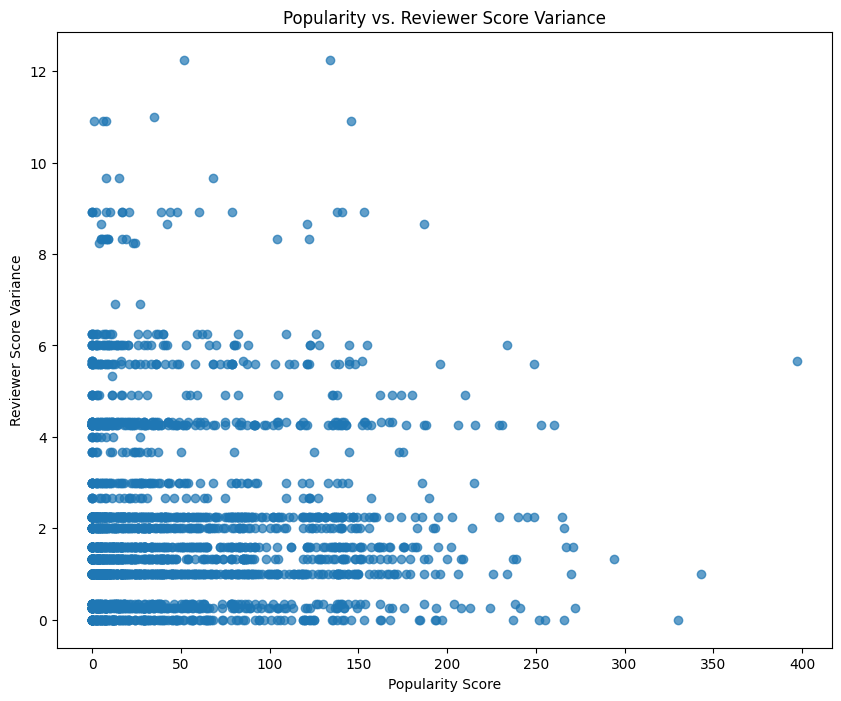

Correlation: 0.021


In [14]:
# Scatter plot
plt.figure(figsize=(10,8))
plt.scatter(df["popularity_score"], df["score_variance"], alpha=0.7)
plt.xlabel("Popularity Score")
plt.ylabel("Reviewer Score Variance")
plt.title("Popularity vs. Reviewer Score Variance")

# for i, row in df.iterrows():
#     # Label each point with the paper title (optional)
#     plt.text(row["popularity_score"]+0.01, row["score_variance"]+0.01, row["title"], fontsize=8)

plt.show()

# Calculate correlation:
corr = df["popularity_score"].corr(df["score_variance"])
print(f"Correlation: {corr:.3f}")

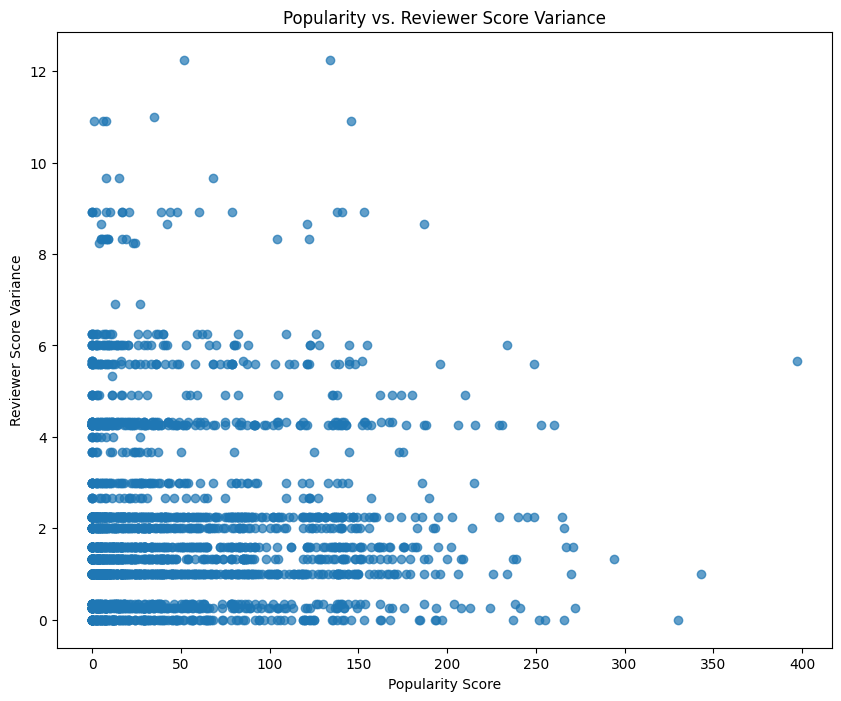

Correlation: 0.021


In [15]:
# Scatter plot
plt.figure(figsize=(10,8))
plt.scatter(df["popularity_score"], df["score_variance"], alpha=0.7)
plt.xlabel("Popularity Score")
plt.ylabel("Reviewer Score Variance")
plt.title("Popularity vs. Reviewer Score Variance")


plt.show()

# Calculate correlation:
corr = df["popularity_score"].corr(df["score_variance"])
print(f"Correlation: {corr:.3f}")

In [16]:
df.iloc[353]["title"]

'Decepticons: Corrupted Transformers Breach Privacy in Federated Learning for Language Models'

In [17]:
df[df["title"] == 'Decepticons: Corrupted Transformers Breach Privacy in Federated Learning for Language Models']["decision"]

508    Accept
Name: decision, dtype: object

Global Keyword Frequencies:
                         keyword  global_freq
0        reinforcement learning          135
5                 deep learning          117
98      representation learning          102
76     self-supervised learning           83
154          federated learning           78
...                         ...          ...
1922              coding theory            1
1923     wireless communication            1
1925                  pac codes            1
1928  offline policy evaluation            1
4500             bev perception            1

[4501 rows x 2 columns]

Correlation between popularity_score and acceptance (1=Accept, 0=Reject): -0.01093437396533257


<Figure size 600x400 with 0 Axes>

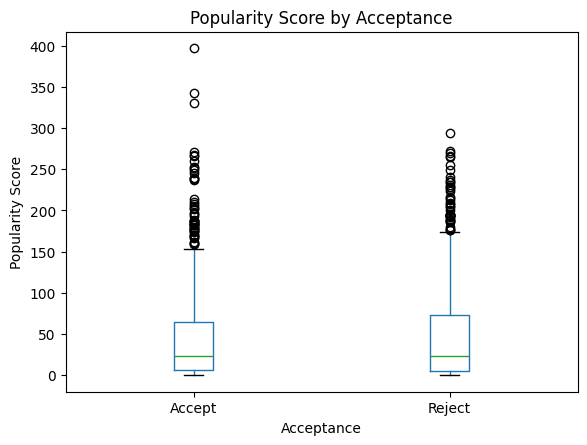

In [18]:
# =================================
# 2. Clean and Normalize Keywords
# =================================
def split_and_normalize(kw_string):
    if pd.isna(kw_string):
        return []
    tokens = kw_string.split(";")
    return [t.strip().lower() for t in tokens if t.strip()]

df["keyword_list"] = df["keywords"].apply(split_and_normalize)

# =================================
# 3. Compute Global Keyword Frequencies
# =================================
all_keywords = []
for kw_list in df["keyword_list"]:
    all_keywords.extend(kw_list)
freq_counter = Counter(all_keywords)

# Optional: see the frequencies
freq_df = pd.DataFrame(freq_counter.items(), columns=["keyword", "global_freq"])
freq_df.sort_values("global_freq", ascending=False, inplace=True)
print("Global Keyword Frequencies:\n", freq_df)

# =================================
# 4. Popularity Score for Each Paper
# =================================
def compute_popularity_score(kw_list):
    return sum(freq_counter[k] for k in kw_list)

df["popularity_score"] = df["keyword_list"].apply(compute_popularity_score)

# =================================
# 5. Convert Acceptance to Numeric
# =================================
#  "Accept" -> 1, "Reject" -> 0
df["acceptance_num"] = df["decision"].map({"Accept": 1, "Reject": 0})

# =================================
# 6. Correlation
# =================================
corr = df["popularity_score"].corr(df["acceptance_num"])
print("\nCorrelation between popularity_score and acceptance (1=Accept, 0=Reject):", corr)

# =================================
# 7. (Optional) Visualization
# =================================
# A quick boxplot or scatter might help too:
plt.figure(figsize=(6,4))
df.boxplot(column="popularity_score", by="decision", grid=False)
plt.title("Popularity Score by Acceptance")
plt.suptitle("")  # remove default title
plt.xlabel("Acceptance")
plt.ylabel("Popularity Score")
plt.show()

In [23]:
def create_feature_summary_excluding_reviewers(df: pd.DataFrame, sample_rows=2) -> pd.DataFrame:
    # Exclude columns related to reviewers by filtering them out
    exclude_patterns = ["reviewer"]  # Adjust if needed
    filtered_columns = [col for col in df.columns if not any(pattern in col for pattern in exclude_patterns)]
    
    # Prepare lists to store summary info
    columns = []
    dtypes = []
    null_counts = []
    unique_counts = []
    sample_values_list = []

    for col in filtered_columns:
        columns.append(col)
        dtypes.append(df[col].dtype)

        # Count missing (NaN) values
        null_counts.append(df[col].isna().sum())

        # Count unique values
        try:
            unique_counts.append(df[col].nunique(dropna=True))
        except TypeError:
            # Handle unhashable types like lists
            unique_counts.append(len(set(map(str, df[col].dropna()))))

        # Get a short sample of values (for presentation)
        sample_values = df[col].dropna().head(sample_rows).tolist()
        sample_values_str = ", ".join(map(str, sample_values))
        sample_values_list.append(sample_values_str)

    # Build a DataFrame with the collected info
    summary_df = pd.DataFrame({
        "Feature": columns,
        "Data Type": dtypes,
        "Null Count": null_counts,
        "Unique Count": unique_counts,
        "Sample Values": sample_values_list
    })

    return summary_df

create_feature_summary_excluding_reviewers(df)

,Feature,Data Type,Null Count,Unique Count,Sample Values
0,title,object,0,2628,Guiding Safe Exploration with Weakest Precondi...
1,keywords,object,370,2249,reinforcement learning; safe learning; safe ex...
2,TL;DR,object,792,1835,"We use an online, weakest-precondition-based a..."
3,abstract,object,0,2628,In reinforcement learning for safety-critical ...
4,cdate,object,0,780,"2022-09-22 14:36:24, 2022-09-22 14:32:39"
5,tmdate,object,0,1035,"2024-11-25 10:13:40, 2023-02-14 00:29:06"
6,decision,object,0,2,"Accept, Reject"
7,paper_no,int64,0,2628,"0, 2"
8,max_score,int64,0,6,"8, 6"
9,min_score,int64,0,5,"6, 3"


In [21]:
 df.columns

Index(['title', 'keywords', 'TL;DR', 'abstract', 'cdate', 'tmdate',
       'reviewer1_score', 'reviewer1_confidence',
       'reviewer1_summary_of_the_paper', 'reviewer1_strength_and_weaknesses',
       'reviewer1_clarity_quality_novelty_and_reproducibility',
       'reviewer1_summary_of_the_review', 'reviewer1_correctness',
       'reviewer1_technical_novelty_and_significance',
       'reviewer1_empirical_novelty_and_significance',
       'reviewer1_flag_for_ethics_review', 'reviewer1_length',
       'reviewer1_cdate', 'reviewer1_tmdate', 'reviewer2_score',
       'reviewer2_confidence', 'reviewer2_summary_of_the_paper',
       'reviewer2_strength_and_weaknesses',
       'reviewer2_clarity_quality_novelty_and_reproducibility',
       'reviewer2_summary_of_the_review', 'reviewer2_correctness',
       'reviewer2_technical_novelty_and_significance',
       'reviewer2_empirical_novelty_and_significance',
       'reviewer2_flag_for_ethics_review', 'reviewer2_length',
       'reviewer2_cdat